# Multi-Objective Reservoir Optimization Showcase

This notebook demonstrates multi-objective optimization for a realistic water system using taqsim.

---

## Learning Objectives

By the end of this notebook, you will understand:

1. **Multi-objective optimization**: How to balance competing goals that cannot all be optimized simultaneously
2. **Pareto optimality**: What it means for a solution to be "non-dominated" and why there's no single "best" answer
3. **Genetic algorithms (NSGA-II)**: How evolutionary optimization explores complex parameter spaces
4. **Reservoir operations**: How release rules and allocation strategies affect water system performance
5. **Trade-off visualization**: How to interpret Pareto fronts, parallel coordinates, and convergence plots

---

## Problem Overview

We optimize a reservoir system with **72 tunable parameters** across **4 competing objectives**:

| Objective | Direction | What it measures |
|-----------|-----------|------------------|
| Hydropower | Maximize | Electricity generated at the turbine |
| City Flood | Minimize | Water spillage when flow exceeds city capacity |
| Irrigation Deficit | Minimize | Unmet water demand for agriculture |
| Thermal Deficit | Minimize | Unmet cooling water for power plant |

**The core challenge**: These objectives conflict with each other. More water release generates more power but increases flood risk. Water allocated to irrigation cannot go to the thermal plant.

**The solution**: Instead of finding one "optimal" answer, we find the **Pareto front** — the set of all solutions where improving one objective necessarily worsens another.

## Setup and Imports

Before we begin, let's import the necessary libraries:

| Library | Purpose |
|---------|---------|
| `numpy` | Numerical computations and array operations |
| `matplotlib` | Static visualizations (Pareto plots, time series) |
| `pandas` | Data manipulation for results analysis |
| `plotly` | Interactive visualizations (parallel coordinates) |
| `taqsim` | Water system simulation framework |
| `ctrl_freak` | Multi-objective optimization (NSGA-II) |
| `pymoo` | Hypervolume indicator for optimization quality |

The `taqsim` framework provides:
- **Node types**: Source, Storage, Demand, Splitter, PassThrough, Sink
- **Events**: Track water flow through the system (WaterStored, WaterSpilled, etc.)
- **Strategies**: Customizable rules for release and allocation decisions
- **Optimization**: Interface to genetic algorithms for parameter tuning

In [1]:
from dataclasses import dataclass
from typing import ClassVar

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px

from taqsim import (
    Demand,
    Edge,
    LossReason,
    Objective,
    Ordered,
    PassThrough,
    Sink,
    Source,
    Splitter,
    Storage,
    Strategy,
    TimeSeries,
    WaterSystem,
    lift,
    optimize,
)
from taqsim.node.events import (
    DeficitRecorded,
    WaterPassedThrough,
    WaterReceived,
    WaterSpilled,
    WaterStored,
)

TIMESTEPS = 120
SEED = 96530  # From exploration trial 0

## Time Series Generation

Generate realistic seasonal patterns for river inflows and demands:
- **Inflows**: Peak in summer (months 5-7), low in winter, with random variability and occasional extreme events
- **Irrigation demand**: Peak in summer growing season (months 6-8), zero in winter
- **Thermal demand**: Higher in summer (more cooling needed), relatively stable baseline

In [ ]:
# Configuration from exploration trial 0
INFLOW_SCALE = 0.89
IRRIGATION_PEAK = 25.4
THERMAL_BASE = 24.1
CITY_CAPACITY = 41.0


def generate_inflows(n_years: int = 10, mean_annual: float = 100.0, seed: int = 42) -> list[float]:
    """Generate monthly river inflows with seasonal pattern and variability."""
    rng = np.random.default_rng(seed)
    seasonal = [0.5, 0.6, 0.8, 1.2, 1.6, 1.8, 1.5, 1.0, 0.7, 0.5, 0.4, 0.4]

    inflows = []
    for year in range(n_years):
        year_factor = rng.uniform(0.8, 1.2)
        for month, s in enumerate(seasonal):
            noise = rng.uniform(0.9, 1.1)
            extreme = 1.8 if rng.random() < 0.08 else 1.0
            inflows.append(mean_annual * s * year_factor * noise * extreme)
    return inflows


def generate_irrigation_demand(n_years: int = 10, peak_demand: float = 25.0, seed: int = 123) -> list[float]:
    """Generate monthly irrigation demand with growing season pattern."""
    rng = np.random.default_rng(seed)
    seasonal = [0.0, 0.0, 0.2, 0.6, 1.0, 1.4, 1.5, 1.2, 0.7, 0.2, 0.0, 0.0]

    demand = []
    for year in range(n_years):
        for month, s in enumerate(seasonal):
            noise = rng.uniform(0.9, 1.1)
            demand.append(peak_demand * s * noise)
    return demand


def generate_thermal_demand(n_years: int = 10, base_demand: float = 24.0, seed: int = 456) -> list[float]:
    """Generate thermal plant cooling demand - higher in summer when more cooling is needed."""
    rng = np.random.default_rng(seed)
    seasonal = [0.7, 0.7, 0.8, 0.9, 1.1, 1.3, 1.4, 1.3, 1.1, 0.9, 0.8, 0.7]

    demand = []
    for year in range(n_years):
        for month, s in enumerate(seasonal):
            noise = rng.uniform(0.95, 1.05)
            demand.append(base_demand * s * noise)
    return demand


inflows = generate_inflows(n_years=10, mean_annual=100.0 * INFLOW_SCALE, seed=SEED)
irrigation_demand = generate_irrigation_demand(n_years=10, peak_demand=IRRIGATION_PEAK, seed=SEED + 1)
thermal_demand = generate_thermal_demand(n_years=10, base_demand=THERMAL_BASE, seed=SEED + 2)

print(f"Generated {len(inflows)} timesteps of data")
print(f"Total inflow: {sum(inflows):.1f}, Mean: {np.mean(inflows):.1f}")
print(f"Total irrigation demand: {sum(irrigation_demand):.1f}, Mean: {np.mean(irrigation_demand):.1f}")
print(f"Total thermal demand: {sum(thermal_demand):.1f}, Mean: {np.mean(thermal_demand):.1f}")

## Operating Strategies: The 72 Parameters

The optimizer doesn't control the water directly — it tunes **operating rules** that the reservoir follows during simulation. These rules have parameters that vary by month, creating seasonal adaptation.

### Understanding the Parameter Space

The optimizer searches through a **72-dimensional space**:

```
Total parameters = (5 SLOP params × 12 months) + (1 split param × 12 months) = 72
```

Each combination of 72 numbers represents a complete **operating policy** — a year-round strategy for how the reservoir should behave.

---

### Strategy 1: SLOP Release Rule (60 parameters)

**SLOP** = Storage Level Operating Policy. It decides how much water to release based on current storage level.

The release follows a **piecewise linear function** with three zones:

```
Release
   ↑
   |           ╱ Flood control zone (slope m2)
   |         ╱
   |--------w-------- Normal zone (constant release)
   |       ╱
   |     ╱ Conservation zone (slope m1)
   |   ╱
   +--h1----h2----→ Water Level (head)
```

| Parameter | Meaning | Typical Range |
|-----------|---------|---------------|
| `h1` | Low threshold — below this, conserve water | 20-100 m |
| `h2` | High threshold — above this, release extra | 20-100 m |
| `w` | Base release rate in normal zone | 0-80 units |
| `m1` | How aggressively to reduce release when low | 0.01-2.0 |
| `m2` | How aggressively to increase release when high | 0.01-2.0 |

**Why 60 parameters?** Each of these 5 values can be different for each month:
- January might have `w=30` (low release, conserve for dry season)
- July might have `w=55` (high release, manage flood inflows)

---

### Strategy 2: Seasonal Split Ratio (12 parameters)

The **splitter node** divides water between irrigation and thermal plant. The `irrigation_fraction` parameter (0.1 to 0.9) controls this split for each month:

| Month | If `irrigation_fraction = 0.7` |
|-------|--------------------------------|
| July (peak irrigation) | 70% → irrigation, 30% → thermal |
| January (no crops) | Could be set to 0.2 → 20% irrigation, 80% thermal |

This creates direct competition: **every drop sent to irrigation is unavailable for thermal cooling**.

In [3]:
def volume_to_head(
    volume: float, v_dead: float = 10.0, v_max: float = 150.0, h_dead: float = 20.0, h_max: float = 100.0
) -> float:
    """Convert reservoir volume to hydraulic head (water level)."""
    v_clamped = max(v_dead, min(v_max, volume))
    return h_dead + (v_clamped - v_dead) * (h_max - h_dead) / (v_max - v_dead)


@dataclass(frozen=True)
class SLOPRelease(Strategy):
    """Storage Level Operating Policy with time-varying monthly parameters."""

    __params__: ClassVar[tuple[str, ...]] = ("h1", "h2", "w", "m1", "m2")
    __bounds__: ClassVar[dict[str, tuple[float, float]]] = {
        "h1": (20.0, 100.0),
        "h2": (20.0, 100.0),
        "w": (0.0, 80.0),
        "m1": (0.01, 2.0),
        "m2": (0.01, 2.0),
    }
    __constraints__: ClassVar[tuple] = (Ordered(low="h1", high="h2"),)
    __time_varying__: ClassVar[tuple[str, ...]] = ("h1", "h2", "w", "m1", "m2")
    __cyclical__: ClassVar[tuple[str, ...]] = ("h1", "h2", "w", "m1", "m2")

    h1: tuple[float, ...] = (40.0,) * 12
    h2: tuple[float, ...] = (70.0,) * 12
    w: tuple[float, ...] = (40.0,) * 12
    m1: tuple[float, ...] = (0.5,) * 12
    m2: tuple[float, ...] = (0.8,) * 12

    def release(self, node: Storage, inflow: float, t: int, dt: float) -> float:
        head = volume_to_head(node.storage)
        month = t % 12

        h1_t = self.h1[month]
        h2_t = self.h2[month]
        w_t = self.w[month]
        m1_t = self.m1[month]
        m2_t = self.m2[month]

        # Piecewise linear SLOP policy
        if head < h1_t:
            # Conservation zone: reduce release linearly
            release = max(0.0, w_t - m1_t * (h1_t - head))
        elif head > h2_t:
            # Flood control zone: increase release linearly
            release = w_t + m2_t * (head - h2_t)
        else:
            # Normal zone: release at base rate
            release = w_t

        # Cannot release more than available (above dead storage)
        available = max(0.0, node.storage - node.dead_storage)
        return min(release * dt, available)


@dataclass(frozen=True)
class SeasonalRatio(Strategy):
    """Time-varying split ratio between irrigation and thermal plant."""

    __params__: ClassVar[tuple[str, ...]] = ("irrigation_fraction",)
    __bounds__: ClassVar[dict[str, tuple[float, float]]] = {"irrigation_fraction": (0.1, 0.9)}
    __time_varying__: ClassVar[tuple[str, ...]] = ("irrigation_fraction",)
    __cyclical__: ClassVar[tuple[str, ...]] = ("irrigation_fraction",)

    irrigation_fraction: tuple[float, ...] = (0.5,) * 12

    def split(self, node: Splitter, amount: float, t: int) -> dict[str, float]:
        frac = self.irrigation_fraction[t % 12]
        return {
            "irrigation": amount * frac,
            "thermal_plant": amount * (1.0 - frac),
        }


# Count optimizable parameters
slop_params = 5 * 12  # 5 params × 12 months
ratio_params = 1 * 12  # 1 param × 12 months
print(f"SLOP parameters: {slop_params}")
print(f"SeasonalRatio parameters: {ratio_params}")
print(f"Total optimizable parameters: {slop_params + ratio_params}")

SLOP parameters: 60
SeasonalRatio parameters: 12
Total optimizable parameters: 72


## Objectives

We optimize four objectives that capture the key trade-offs in reservoir operations:

### 1. Hydropower (maximize)
Total electricity generated at the turbine over 120 months.

**Formula:** `Power = flow × head × efficiency × gravity`
- **flow**: Water passing through turbine (from reservoir release)
- **head**: Hydraulic head based on reservoir storage level

**Trade-off:** Wants high release for high flow, but excessive release depletes reservoir → lower head.

### 2. City Flood Risk (minimize)
Total water spillage at the city passthrough when flow exceeds capacity (41 units).

**Trade-off:** Wants low release to stay under capacity, directly conflicts with hydropower.

### 3. Irrigation Deficit (minimize)
Total unmet irrigation water demand over the simulation period.

**Trade-off:** Irrigation is fully consumptive (water doesn't return to system) and peaks in summer when inflows are highest but thermal demand also peaks.

### 4. Thermal Plant Deficit (minimize)
Total unmet cooling water demand for the thermal power plant.

**Trade-off:** Thermal demand is non-consumptive (water returns to system) but competes with irrigation for the same water allocation via the splitter.

---

**Key Trade-off:** The SeasonalRatio strategy controls how water is split between irrigation and thermal plant. More water to one means less to the other — creating a direct irrigation vs. thermal trade-off.

## Building the Water System

A water system in taqsim is a **directed graph** where:
- **Nodes** represent physical components (reservoir, turbine, demand points)
- **Edges** represent water conveyance (canals, pipes) with capacity limits

### Node Types Used

| Node Type | Purpose | Example in this system |
|-----------|---------|----------------------|
| `Source` | Water enters the system | River inflow |
| `Storage` | Holds water with release rule | Reservoir (capacity 150 units) |
| `PassThrough` | Conveys water with capacity limit | Turbine (60 units), City (41 units) |
| `Splitter` | Divides flow according to rule | Irrigation/Thermal split |
| `Demand` | Consumes water, records deficit | Irrigation, Thermal plant |
| `Sink` | Water exits the system | End points |

### System Topology

```
River → Reservoir → Turbine → City → Splitter → Irrigation → Sink
                                          ↓
                                    Thermal Plant → Sink
```

### Key Constraints

1. **City capacity (41 units)**: The bottleneck that causes flooding when exceeded
2. **Turbine capacity (60 units)**: Maximum flow through the powerhouse
3. **Irrigation consumption (100%)**: All water is consumed by crops (evapotranspiration)
4. **Thermal consumption (0%)**: Cooling water passes through and returns to the system

In [4]:
from taqsim.node.events import WaterReleased


@lift
def volume_to_head_lifted(v: float) -> float:
    """Lifted version for trace arithmetic."""
    return 20.0 + (max(10.0, min(150.0, v)) - 10.0) * 80.0 / 140.0


def hydropower_objective(
    reservoir_id: str, turbine_id: str, initial_storage: float = 75.0, efficiency: float = 0.85
) -> Objective:
    """Maximize hydropower generation using dynamic head."""

    def evaluate(system: WaterSystem) -> float:
        turbine = system.nodes[turbine_id]
        reservoir = system.nodes[reservoir_id]

        flow_trace = turbine.trace(WaterPassedThrough)
        stored_trace = reservoir.trace(WaterStored)
        released_trace = reservoir.trace(WaterReleased)

        net_change = stored_trace - released_trace
        storage_trace = net_change.cumsum(initial=initial_storage)
        head_trace = storage_trace.map(volume_to_head_lifted)

        power_trace = flow_trace * head_trace * (9810 * efficiency / 1e9)
        return power_trace.sum()

    return Objective(name="hydropower", direction="maximize", evaluate=evaluate)


def flood_objective(node_id: str) -> Objective:
    """Minimize flood risk (spillage) at a passthrough node."""

    def evaluate(system: WaterSystem) -> float:
        return system.nodes[node_id].trace(WaterSpilled).sum()

    return Objective(name="city_flood", direction="minimize", evaluate=evaluate)


def deficit_objective(node_id: str, name: str | None = None) -> Objective:
    """Minimize water deficit at a demand node."""

    def evaluate(system: WaterSystem) -> float:
        return system.nodes[node_id].trace(DeficitRecorded, field="deficit").sum()

    return Objective(name=name or f"{node_id}_deficit", direction="minimize", evaluate=evaluate)

In [5]:
# Create strategy instances
slop_rule = SLOPRelease()
seasonal_ratio = SeasonalRatio()


@dataclass(frozen=True)
class ZeroEdgeLoss:
    """Edge loss rule with no losses."""

    def calculate(self, edge: Edge, flow: float, t: int, dt: float) -> dict[LossReason, float]:
        return {}


@dataclass(frozen=True)
class ZeroStorageLoss:
    """Storage loss rule with no losses."""

    def calculate(self, node: Storage, t: int, dt: float) -> dict[LossReason, float]:
        return {}


zero_edge_loss = ZeroEdgeLoss()
zero_storage_loss = ZeroStorageLoss()

# Build system
system = WaterSystem(dt=1.0)

# Add nodes with schematic locations for visualization
system.add_node(Source(id="river", inflow=TimeSeries(inflows), location=(5.0, 0.0)))
system.add_node(
    Storage(
        id="reservoir",
        capacity=150.0,
        dead_storage=10.0,
        initial_storage=75.0,
        release_rule=slop_rule,
        loss_rule=zero_storage_loss,
        location=(4.0, 0.0),
    )
)
system.add_node(PassThrough(id="turbine", capacity=60.0, location=(3.0, 0.0)))
system.add_node(PassThrough(id="city", capacity=CITY_CAPACITY, location=(2.0, 0.0)))  # Flood risk bottleneck
system.add_node(Splitter(id="splitter", split_rule=seasonal_ratio, location=(1.0, 0.0)))
system.add_node(
    Demand(
        id="irrigation",
        requirement=TimeSeries(irrigation_demand),
        consumption_fraction=1.0,  # Fully consumptive
        efficiency=0.85,
        location=(0.0, -0.5),
    )
)
system.add_node(
    Demand(
        id="thermal_plant",
        requirement=TimeSeries(thermal_demand),
        consumption_fraction=0.0,  # Non-consumptive (cooling water passes through)
        efficiency=1.0,
        location=(0.0, 0.5),
    )
)
system.add_node(Sink(id="irrigation_sink", location=(-1.0, -0.5)))
system.add_node(Sink(id="thermal_sink", location=(-1.0, 0.5)))

# Add edges
edges = [
    ("e_river_res", "river", "reservoir", 200.0),
    ("e_res_turb", "reservoir", "turbine", 80.0),
    ("e_turb_city", "turbine", "city", 80.0),
    ("e_city_split", "city", "splitter", 80.0),
    ("e_split_irr", "splitter", "irrigation", 80.0),
    ("e_split_therm", "splitter", "thermal_plant", 80.0),
    ("e_irr_sink", "irrigation", "irrigation_sink", 80.0),
    ("e_therm_sink", "thermal_plant", "thermal_sink", 80.0),
]
for id_, src, tgt, cap in edges:
    system.add_edge(Edge(id=id_, source=src, target=tgt, capacity=cap, loss_rule=zero_edge_loss))

# Validate system structure
system.validate()
print("System validated successfully!")
print(f"Nodes: {len(system.nodes)}")
print(f"Edges: {len(system.edges)}")

System validated successfully!
Nodes: 9
Edges: 8


## Multi-Objective Optimization with NSGA-II

### Why Not Just Optimize One Thing?

In single-objective optimization, there's one "best" answer. But with multiple competing objectives, **there is no single best solution** — only trade-offs.

Consider two solutions:
- **Solution A**: Hydropower = 4.5 GWh, City Flood = 1600
- **Solution B**: Hydropower = 3.0 GWh, City Flood = 900

Which is better? **Neither dominates the other** — A has more power, B has less flooding. The choice depends on what the decision-maker values.

### Pareto Dominance

Solution X **dominates** solution Y if:
1. X is at least as good as Y in ALL objectives
2. X is strictly better than Y in AT LEAST ONE objective

Solutions that are **not dominated by any other** form the **Pareto front**.

### NSGA-II Algorithm

**NSGA-II** (Non-dominated Sorting Genetic Algorithm II) is a popular multi-objective optimizer:

```
1. Initialize random population of solutions
2. Evaluate all solutions on all objectives
3. Repeat for N generations:
   a. Sort population by Pareto rank (non-dominated = rank 0)
   b. Select parents preferring lower rank and higher crowding distance
   c. Create offspring via crossover and mutation
   d. Combine parents + offspring, keep best N solutions
4. Return final Pareto front
```

**Key concepts:**
- **Population size (100)**: Number of candidate solutions evaluated per generation
- **Generations (50)**: Number of evolutionary cycles
- **Crowding distance**: Encourages diversity along the Pareto front
- **Crossover/Mutation**: Genetic operators that explore the parameter space

### Tracking Convergence

We track optimization progress via:
1. **Pareto front size**: How many non-dominated solutions exist
2. **Objective ranges**: Min/max/mean values on the Pareto front
3. **Hypervolume**: Volume of objective space dominated by the Pareto front (higher = better)

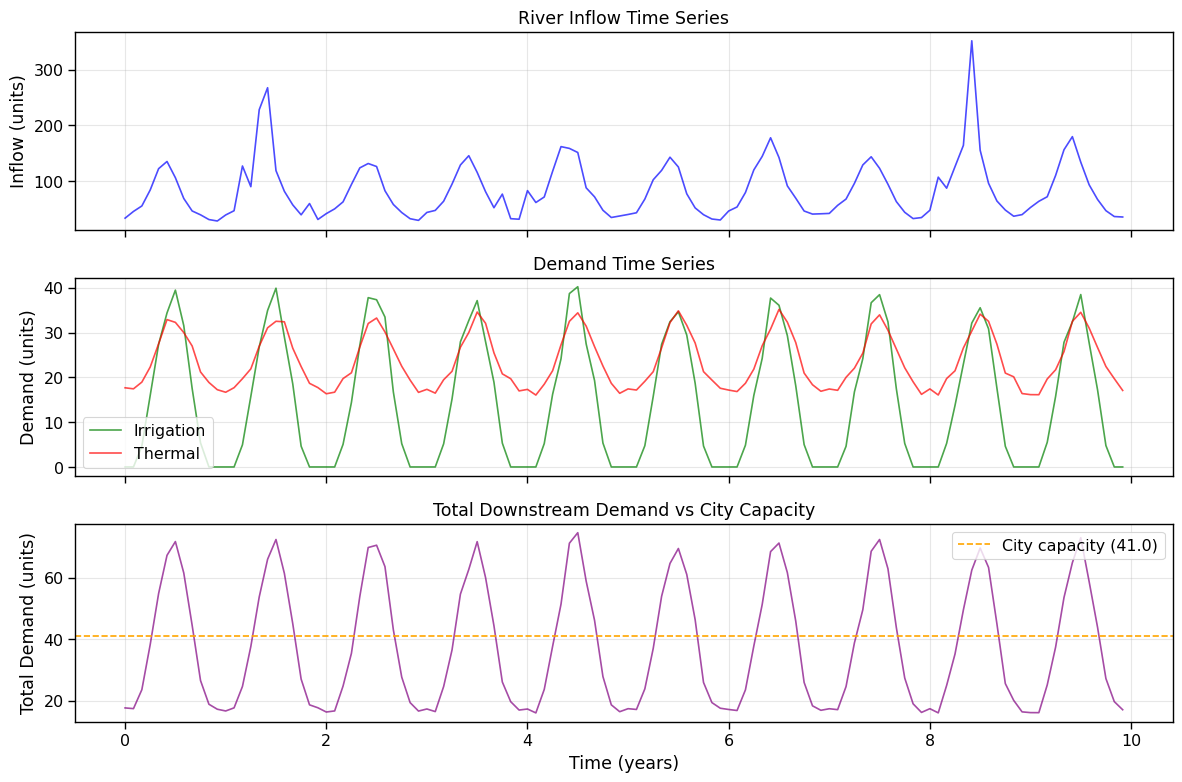

In [7]:
# Visualize input time series
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

months = np.arange(TIMESTEPS)
years = months / 12

axes[0].plot(years, inflows, "b-", alpha=0.7)
axes[0].set_ylabel("Inflow (units)")
axes[0].set_title("River Inflow Time Series")
axes[0].grid(True, alpha=0.3)

axes[1].plot(years, irrigation_demand, "g-", alpha=0.7, label="Irrigation")
axes[1].plot(years, thermal_demand, "r-", alpha=0.7, label="Thermal")
axes[1].set_ylabel("Demand (units)")
axes[1].set_title("Demand Time Series")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].plot(years, [sum(x) for x in zip(irrigation_demand, thermal_demand)], "purple", alpha=0.7)
axes[2].axhline(y=CITY_CAPACITY, color="orange", linestyle="--", label=f"City capacity ({CITY_CAPACITY})")
axes[2].set_ylabel("Total Demand (units)")
axes[2].set_xlabel("Time (years)")
axes[2].set_title("Total Downstream Demand vs City Capacity")
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Multi-Objective Optimization

Run NSGA-II to find Pareto-optimal solutions balancing four competing objectives:
- **Maximize** hydropower generation
- **Minimize** city flooding
- **Minimize** irrigation deficit
- **Minimize** thermal plant deficit

The optimizer tunes all 72 parameters (60 SLOP + 12 SeasonalRatio) to explore the trade-off surfaces between power generation, flood risk, and demand satisfaction.

In [8]:
from ctrl_freak import Population
from pymoo.indicators.hv import HV


def make_history_callback(
    objectives: list[Objective],
) -> tuple[callable, dict]:
    """Create callback that collects per-generation Pareto front statistics including hypervolume."""
    # Reference point for hypervolume (must dominate all solutions)
    # All objectives stored in minimize form internally (maximize objectives are negated)
    # [hydropower(negated), city_flood, irrigation_deficit, thermal_deficit]
    ref_point = np.array([0.0, 2500.0, 2000.0, 2500.0])
    hv_indicator = HV(ref_point=ref_point)

    history: dict = {
        "generation": [],
        "n_pareto": [],
        "hypervolume": [],
        "obj_min": {obj.name: [] for obj in objectives},
        "obj_max": {obj.name: [] for obj in objectives},
        "obj_mean": {obj.name: [] for obj in objectives},
    }

    def callback(pop: Population, gen: int) -> bool:
        pareto_mask = pop.rank == 0
        pareto_obj = pop.objectives[pareto_mask]

        history["generation"].append(gen)
        history["n_pareto"].append(int(pareto_mask.sum()))

        # Calculate hypervolume (objectives already in minimize form)
        hv = hv_indicator(pareto_obj)
        history["hypervolume"].append(float(hv))

        for i, obj in enumerate(objectives):
            vals = pareto_obj[:, i].copy()
            if obj.direction == "maximize":
                vals = -vals
            history["obj_min"][obj.name].append(float(vals.min()))
            history["obj_max"][obj.name].append(float(vals.max()))
            history["obj_mean"][obj.name].append(float(vals.mean()))

        return False

    return callback, history

In [ ]:
# Reset system for optimization
system.reset()

# Define objectives and create history callback
objectives_list = [
    hydropower_objective("reservoir", "turbine", initial_storage=75.0),
    flood_objective("city"),
    deficit_objective("irrigation"),
    deficit_objective("thermal_plant"),
]
history_callback, history = make_history_callback(objectives_list)

# Run optimization with 4 objectives
result = optimize(
    system=system,
    objectives=objectives_list,
    timesteps=TIMESTEPS,
    pop_size=100,
    generations=50,
    seed=SEED,
    verbose=True,
    callback=history_callback,
)

print(f"\nOptimization complete!")
print(f"Found {len(result.solutions)} Pareto-optimal solutions")

## Optimization Convergence

### How to Read Convergence Plots

Convergence plots show whether the optimization is working and when to stop:

**1. Pareto Front Size**
- Should grow initially as the algorithm discovers non-dominated solutions
- Eventually stabilizes when the front is well-populated
- Maximum = population size (100 in our case)

**2. Objective Ranges (min-max bands)**
- The **band width** shows diversity on the Pareto front
- **Min values** should improve (decrease for minimize, increase for maximize)
- If bands keep changing significantly, optimization hasn't converged

**3. Hypervolume**
- Single metric summarizing Pareto front quality
- **Higher = better** (more of objective space is dominated)
- Should increase monotonically and eventually plateau
- Rapid early growth → good exploration
- Flattening → convergence achieved

### Reference Point for Hypervolume

Hypervolume requires a **reference point** that is dominated by all Pareto solutions. We use conservative values worse than any expected solution:

| Objective | Reference Value | Rationale |
|-----------|-----------------|-----------|
| Hydropower | 0.0 GWh | Worst possible (no generation) |
| City Flood | 2500 | Well above observed maximum |
| Irrigation Deficit | 2000 | Above maximum demand |
| Thermal Deficit | 2500 | Above maximum demand |

In [10]:
# Extract all objective scores
hp = np.array([s.scores["hydropower"] for s in result.solutions])
fl = np.array([s.scores["city_flood"] for s in result.solutions])
irr_def = np.array([s.scores["irrigation_deficit"] for s in result.solutions])
therm_def = np.array([s.scores["thermal_plant_deficit"] for s in result.solutions])

# Summary statistics for all objectives
print("=== Pareto Front Statistics (4 Objectives) ===\n")
print(f"{'Objective':<25} {'Min':>10} {'Max':>10} {'Range':>10}")
print("-" * 55)
print(f"{'Hydropower (GWh)':<25} {hp.min():>10.2f} {hp.max():>10.2f} {hp.max() - hp.min():>10.2f}")
print(f"{'City Flood':<25} {fl.min():>10.1f} {fl.max():>10.1f} {fl.max() - fl.min():>10.1f}")
print(f"{'Irrigation Deficit':<25} {irr_def.min():>10.1f} {irr_def.max():>10.1f} {irr_def.max() - irr_def.min():>10.1f}")
print(f"{'Thermal Deficit':<25} {therm_def.min():>10.1f} {therm_def.max():>10.1f} {therm_def.max() - therm_def.min():>10.1f}")

print(f"\nTotal Pareto-optimal solutions: {len(result.solutions)}")

=== Pareto Front Statistics (4 Objectives) ===

Objective                        Min        Max      Range
-------------------------------------------------------
Hydropower (GWh)                1.35       4.61       3.25
City Flood                     803.5     1853.9     1050.4
Irrigation Deficit             113.2     1298.4     1185.3
Thermal Deficit                  6.9     1739.0     1732.1

Total Pareto-optimal solutions: 100


## Interpreting Pairwise Pareto Fronts

When we have 4 objectives, we can't visualize the full 4D Pareto front directly. Instead, we project it onto 2D pairs.

### What to Look For

**1. Shape of the scatter**

| Pattern | Interpretation |
|---------|---------------|
| **Clear front/curve** | Direct trade-off between these two objectives |
| **Scattered cloud** | No direct relationship; trade-off mediated by other objectives |
| **Tight cluster** | Objectives can be satisfied simultaneously |

**2. Color encoding**

We color points by a third objective to see 3-way relationships:
- If color varies systematically along the front → three-way trade-off
- If color is random → the third objective is independent

### Expected Patterns in This Problem

| Plot | Expected Pattern | Why |
|------|-----------------|-----|
| Hydropower vs City Flood | **Clear front** | Direct conflict: more release → more power AND more flooding |
| Irrigation vs Thermal | **Clear front** | Direct conflict: splitter allocates between them |
| Hydropower vs Irrigation | **Cloud** | No direct link; both affected by release level differently |
| Hydropower vs Thermal | **Cloud** | No direct link; connected through system dynamics |

### Correlation Matrix

The correlation between objectives on the Pareto front tells us:
- **Strong negative correlation (-1)**: Direct trade-off
- **Near zero correlation**: Independent or complex relationship
- **Strong positive correlation (+1)**: Objectives align (unusual on Pareto front)

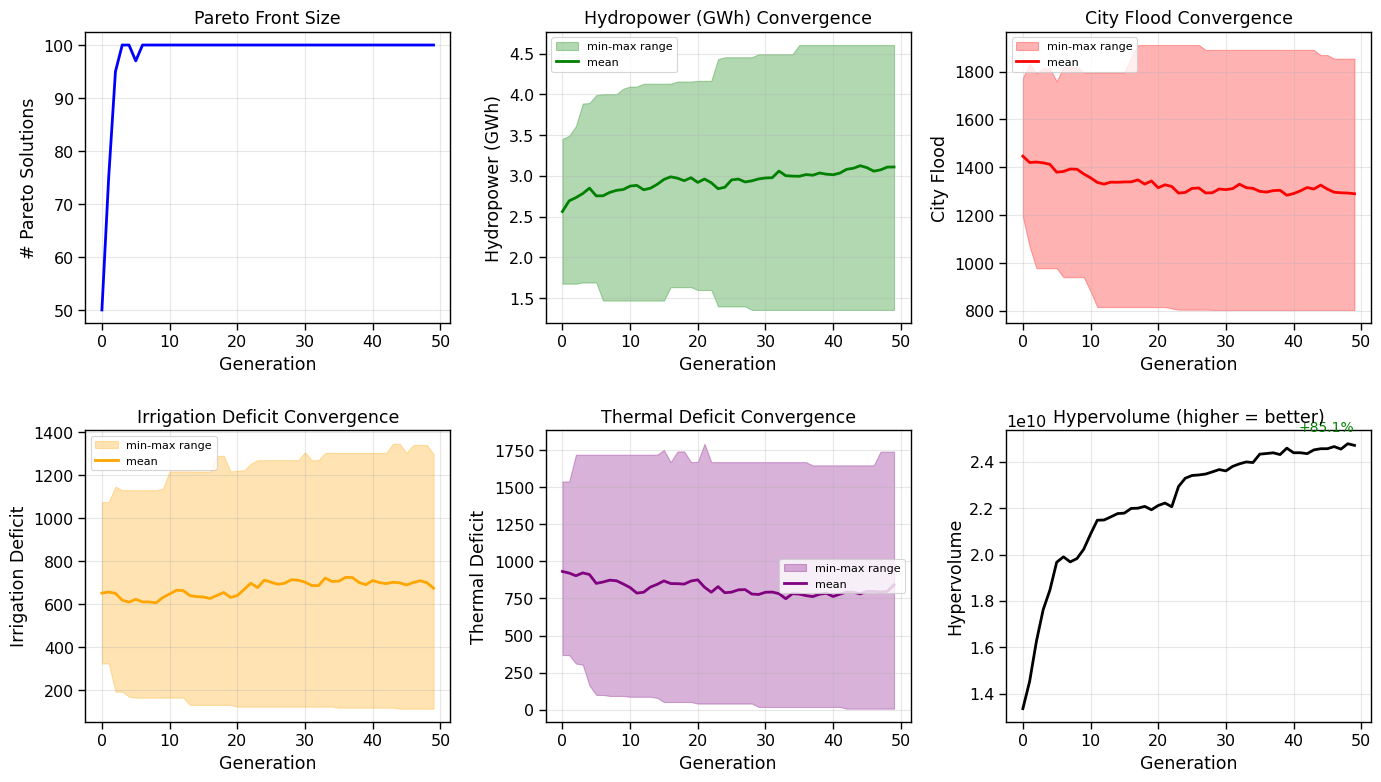


=== Final Generation Statistics ===
Pareto front size: 100 solutions
Hypervolume: 2.47e+10 (improved 85.1% from gen 0)
Hydropower (GWh): 1.35 - 4.61 (mean: 3.11)
City Flood: 803.54 - 1853.93 (mean: 1289.33)
Irrigation Deficit: 113.15 - 1298.45 (mean: 674.08)
Thermal Deficit: 6.87 - 1738.95 (mean: 841.81)


In [11]:
# Plot optimization convergence
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
gens = history["generation"]

# Plot 1: Pareto front size
ax = axes[0, 0]
ax.plot(gens, history["n_pareto"], "b-", linewidth=2)
ax.set_xlabel("Generation")
ax.set_ylabel("# Pareto Solutions")
ax.set_title("Pareto Front Size")
ax.grid(True, alpha=0.3)

# Plot 2-5: Objective convergence with min/max bands
obj_names = ["hydropower", "city_flood", "irrigation_deficit", "thermal_plant_deficit"]
obj_labels = ["Hydropower (GWh)", "City Flood", "Irrigation Deficit", "Thermal Deficit"]
colors = ["green", "red", "orange", "purple"]

for i, (obj_name, label, color) in enumerate(zip(obj_names, obj_labels, colors)):
    row, col = divmod(i + 1, 3)
    ax = axes[row, col]

    obj_min = history["obj_min"][obj_name]
    obj_max = history["obj_max"][obj_name]
    obj_mean = history["obj_mean"][obj_name]

    ax.fill_between(gens, obj_min, obj_max, alpha=0.3, color=color, label="min-max range")
    ax.plot(gens, obj_mean, color=color, linewidth=2, label="mean")
    ax.set_xlabel("Generation")
    ax.set_ylabel(label)
    ax.set_title(f"{label} Convergence")
    ax.legend(loc="best", fontsize=8)
    ax.grid(True, alpha=0.3)

# Plot 6: Hypervolume
ax = axes[1, 2]
ax.plot(gens, history["hypervolume"], "k-", linewidth=2)
ax.set_xlabel("Generation")
ax.set_ylabel("Hypervolume")
ax.set_title("Hypervolume (higher = better)")
ax.grid(True, alpha=0.3)
# Add percentage improvement annotation
hv_start = history["hypervolume"][0]
hv_end = history["hypervolume"][-1]
improvement = (hv_end - hv_start) / hv_start * 100
ax.annotate(f"+{improvement:.1f}%", xy=(gens[-1], hv_end), xytext=(-40, 10),
            textcoords="offset points", fontsize=10, color="green")

plt.tight_layout()
plt.show()

# Print final statistics
print("\n=== Final Generation Statistics ===")
print(f"Pareto front size: {history['n_pareto'][-1]} solutions")
print(f"Hypervolume: {history['hypervolume'][-1]:.2e} (improved {improvement:.1f}% from gen 0)")
for obj_name, label in zip(obj_names, obj_labels):
    print(f"{label}: {history['obj_min'][obj_name][-1]:.2f} - {history['obj_max'][obj_name][-1]:.2f} (mean: {history['obj_mean'][obj_name][-1]:.2f})")

## Parallel Coordinates: Seeing All 4 Objectives at Once

### What is a Parallel Coordinates Plot?

Unlike scatter plots that show 2 dimensions, parallel coordinates display **many dimensions simultaneously**:
- Each vertical axis represents one objective
- Each line represents one Pareto solution
- The line connects the solution's value on each axis

### How to Read It

1. **Crossing lines** = trade-off (good on one axis means bad on another)
2. **Parallel lines** = objectives that correlate (can be optimized together)
3. **Line bundles** = groups of similar solutions

### Interactive Features

The Plotly version allows **filtering**:
1. **Click and drag** on any axis to select a range
2. Lines outside the range are grayed out
3. **Combine filters** across multiple axes to find specific solutions

**Example queries:**
- "Show me solutions with City Flood < 1000" → drag on City Flood axis
- "Show me high power AND low irrigation deficit" → filter both axes
- "What thermal deficit corresponds to low irrigation deficit?" → filter irrigation, observe thermal

### Decision Support

Parallel coordinates help decision-makers:
1. Understand the **full range** of available trade-offs
2. **Filter** to solutions meeting minimum requirements
3. **Compare** remaining candidates visually
4. Select a final solution based on **priorities**

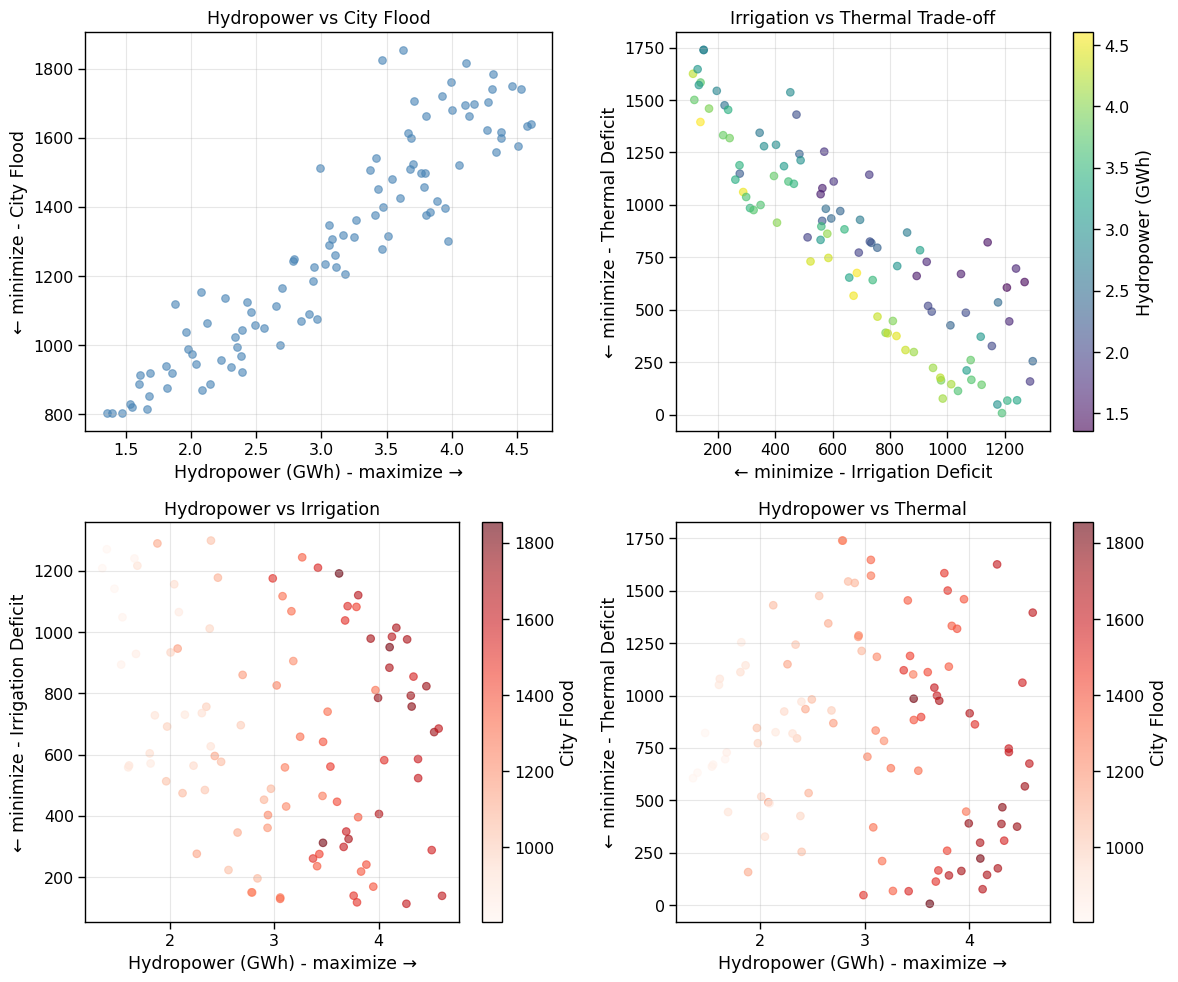


=== Objective Correlations ===

                    Hydropower     City Flood   Irr. Deficit Therm. Deficit
     Hydropower           1.00           0.93          -0.26          -0.11
     City Flood           0.93           1.00          -0.16          -0.22
   Irr. Deficit          -0.26          -0.16           1.00          -0.88
 Therm. Deficit          -0.11          -0.22          -0.88           1.00


In [12]:
# Create 2x2 grid of pairwise Pareto projections
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Hydropower vs City Flood (original trade-off)
ax = axes[0, 0]
ax.scatter(hp, fl, s=30, alpha=0.6, c="steelblue")
ax.set_xlabel("Hydropower (GWh) - maximize →")
ax.set_ylabel("← minimize - City Flood")
ax.set_title("Hydropower vs City Flood")
ax.grid(True, alpha=0.3)

# Plot 2: Irrigation vs Thermal Deficit (new trade-off)
ax = axes[0, 1]
scatter = ax.scatter(irr_def, therm_def, s=30, alpha=0.6, c=hp, cmap="viridis")
ax.set_xlabel("← minimize - Irrigation Deficit")
ax.set_ylabel("← minimize - Thermal Deficit")
ax.set_title("Irrigation vs Thermal Trade-off")
ax.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label("Hydropower (GWh)")

# Plot 3: Hydropower vs Irrigation Deficit
ax = axes[1, 0]
scatter = ax.scatter(hp, irr_def, s=30, alpha=0.6, c=fl, cmap="Reds")
ax.set_xlabel("Hydropower (GWh) - maximize →")
ax.set_ylabel("← minimize - Irrigation Deficit")
ax.set_title("Hydropower vs Irrigation")
ax.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label("City Flood")

# Plot 4: Hydropower vs Thermal Deficit
ax = axes[1, 1]
scatter = ax.scatter(hp, therm_def, s=30, alpha=0.6, c=fl, cmap="Reds")
ax.set_xlabel("Hydropower (GWh) - maximize →")
ax.set_ylabel("← minimize - Thermal Deficit")
ax.set_title("Hydropower vs Thermal")
ax.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label("City Flood")

plt.tight_layout()
plt.show()

# Correlation matrix
print("\n=== Objective Correlations ===")
objectives_matrix = np.column_stack([hp, fl, irr_def, therm_def])
corr = np.corrcoef(objectives_matrix.T)
labels = ["Hydropower", "City Flood", "Irr. Deficit", "Therm. Deficit"]
print(f"\n{'':>15}", end="")
for label in labels:
    print(f"{label:>15}", end="")
print()
for i, row_label in enumerate(labels):
    print(f"{row_label:>15}", end="")
    for j in range(len(labels)):
        print(f"{corr[i, j]:>15.2f}", end="")
    print()

## Water Availability Over Time: Seeing the Strategies in Action

### From Numbers to Understanding

The Pareto front shows us **what** trade-offs exist, but not **how** they arise. Time series visualizations reveal **why** different solutions perform differently.

### Three Representative Strategies

We select three solutions from different regions of the Pareto front:

| Strategy | Philosophy | Expected Behavior |
|----------|------------|-------------------|
| **Low Flood Risk** | Conservative release, prioritize safety | Low reservoir releases, more spillage at reservoir, less at city |
| **Balanced** | Middle ground | Moderate releases, accepts some flooding and some deficits |
| **High Power** | Aggressive release, maximize energy | High releases, depletes reservoir in dry periods, high city flooding |

### What to Look For

**1. Reservoir Storage**
- Does it hit capacity (150 units)? → Spillage at reservoir
- Does it hit dead storage (10 units)? → No water available for release
- Seasonal patterns: filling in wet months, drawing down in dry months

**2. Turbine Flow**
- How often does it exceed city capacity (41 units)? → Flooding events
- How consistent is the flow? → Steady power generation vs. peaks

**3. Irrigation Received vs Required**
- Gap between gray (required) and colored lines = deficit
- Which months have the worst deficits? (Usually peak summer)
- Does the strategy sacrifice irrigation for other objectives?

**4. Thermal Plant Received vs Required**
- Thermal demand is more consistent (less seasonal)
- Non-consumptive: water returns to system (but we model it as an endpoint)
- Trade-off with irrigation is visible here

In [16]:
# Create DataFrame with all objective scores
df_pareto = pd.DataFrame({
    "Hydropower (GWh)": hp,
    "City Flood": fl,
    "Irrigation Deficit": irr_def,
    "Thermal Deficit": therm_def,
})

# Interactive parallel coordinates plot with Plotly
fig = px.parallel_coordinates(
    df_pareto,
    color="Hydropower (GWh)",
    color_continuous_scale="Viridis",
    dimensions=["Hydropower (GWh)", "City Flood", "Irrigation Deficit", "Thermal Deficit"],
    #title="Pareto Front: Parallel Coordinates (drag on axes to filter)",
    title=" ",
)

fig.update_layout(
    height=500,
    margin=dict(l=80, r=80, t=50, b=30),
)

fig.show()

## Summary and Key Takeaways

### What We Learned

1. **Multi-objective optimization finds trade-offs, not single answers**
   - The Pareto front contains 100 solutions, each representing a different balance
   - Decision-makers choose based on their priorities and constraints

2. **72 parameters enable seasonal adaptation**
   - Monthly variation in release rules and allocation ratios
   - The optimizer discovers patterns humans might not design manually

3. **Direct vs indirect trade-offs**
   - Hydropower ↔ City Flood: Direct conflict (same water flow)
   - Irrigation ↔ Thermal: Direct conflict (splitter allocation)
   - Hydropower ↔ Irrigation: Indirect (both benefit from release, but compete via splitter)

4. **Convergence monitoring ensures quality**
   - Hypervolume tracks overall Pareto front improvement
   - 85% improvement over 50 generations indicates good optimization

### Extensions to Explore

- **More generations**: Would the hypervolume continue improving?
- **Different constraints**: What if city capacity were higher?
- **Stochastic inflows**: How robust are these solutions to climate variability?
- **Economic objectives**: Could we price water to create composite objectives?

### Practical Application

In real-world reservoir operations:
1. Generate the Pareto front with stakeholder-defined objectives
2. Filter to solutions meeting hard constraints (e.g., minimum flood protection)
3. Present remaining trade-offs to decision-makers
4. Select operating policy based on societal priorities
5. Implement seasonal rule curves derived from optimized parameters

In [14]:
def simulate_and_extract_traces(
    solution, timesteps: int, initial_storage: float = 75.0
) -> dict[str, np.ndarray]:
    """Apply solution parameters, simulate, and extract key traces."""
    # Create a new system with the solution's optimized parameters
    sys = solution.to_system()
    sys.simulate(timesteps)

    # Extract traces as arrays (filling missing timesteps with 0)
    def trace_to_array(trace, timesteps: int) -> np.ndarray:
        return np.array([trace.get(t, 0.0) for t in range(timesteps)])

    reservoir = sys.nodes["reservoir"]
    turbine = sys.nodes["turbine"]
    city = sys.nodes["city"]
    irrigation = sys.nodes["irrigation"]
    thermal = sys.nodes["thermal_plant"]

    # Compute reservoir storage over time
    stored = trace_to_array(reservoir.trace(WaterStored), timesteps)
    released = trace_to_array(reservoir.trace(WaterReleased), timesteps)
    net_change = stored - released
    storage = np.cumsum(net_change) + initial_storage

    return {
        "reservoir_storage": storage,
        "turbine_flow": trace_to_array(turbine.trace(WaterPassedThrough), timesteps),
        "city_flow": trace_to_array(city.trace(WaterPassedThrough), timesteps),
        "city_spill": trace_to_array(city.trace(WaterSpilled), timesteps),
        "irrigation_received": trace_to_array(irrigation.trace(WaterReceived), timesteps),
        "irrigation_deficit": trace_to_array(irrigation.trace(DeficitRecorded, field="deficit"), timesteps),
        "thermal_received": trace_to_array(thermal.trace(WaterReceived), timesteps),
        "thermal_deficit": trace_to_array(thermal.trace(DeficitRecorded, field="deficit"), timesteps),
    }


# Select representative solutions
min_flood_idx = np.argmin(fl)
max_hp_idx = np.argmax(hp)
# Balanced: sort by hydropower, pick middle
sort_idx = np.argsort(hp)
balanced_idx = sort_idx[len(sort_idx) // 2]

solutions_to_plot = [
    ("Low Flood Risk", result.solutions[min_flood_idx], "C0"),
    ("Balanced", result.solutions[balanced_idx], "C2"),
    ("High Power", result.solutions[max_hp_idx], "C1"),
]

# Print solution characteristics
print("=== Selected Solutions ===\n")
print(f"{'Strategy':<18} {'Hydropower':>12} {'City Flood':>12} {'Irr. Deficit':>14} {'Therm. Deficit':>15}")
print("-" * 75)
for name, sol, _ in solutions_to_plot:
    print(
        f"{name:<18} "
        f"{sol.scores['hydropower']:>12.2f} "
        f"{sol.scores['city_flood']:>12.1f} "
        f"{sol.scores['irrigation_deficit']:>14.1f} "
        f"{sol.scores['thermal_plant_deficit']:>15.1f}"
    )

=== Selected Solutions ===

Strategy             Hydropower   City Flood   Irr. Deficit  Therm. Deficit
---------------------------------------------------------------------------
Low Flood Risk             1.35        803.5         1208.2           605.7
Balanced                   3.11       1226.9          430.6          1184.5
High Power                 4.61       1640.3          139.0          1395.3


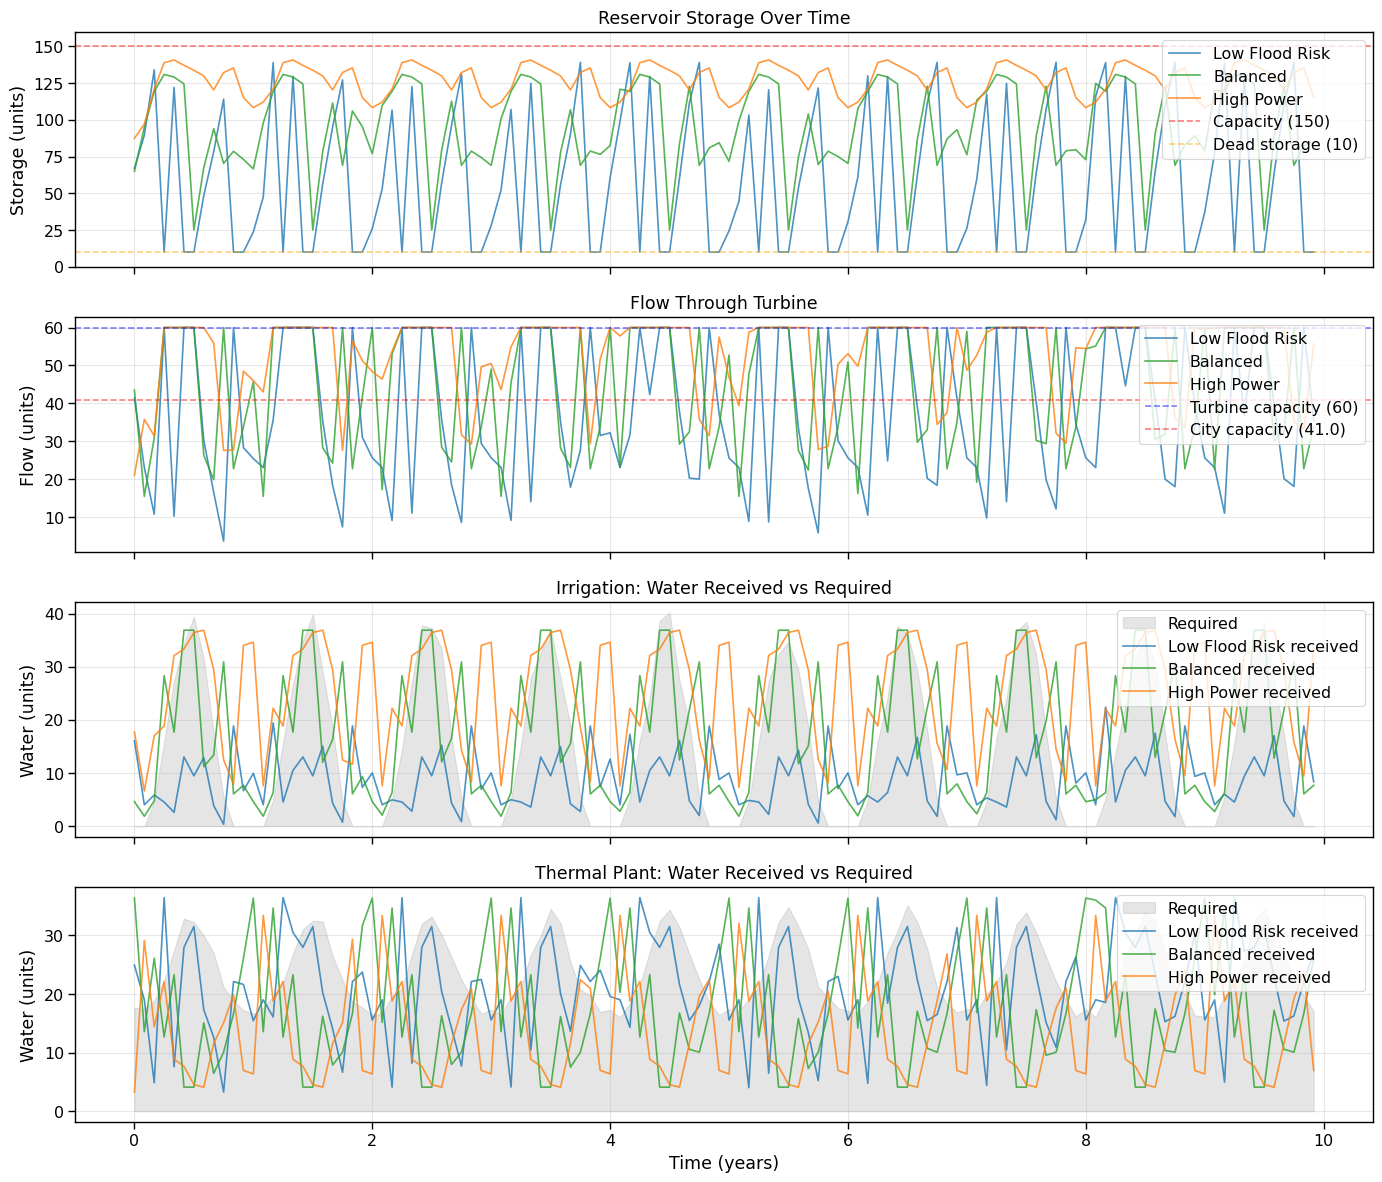

In [15]:
# Simulate each solution and collect traces
all_traces = {}
for name, sol, color in solutions_to_plot:
    all_traces[name] = simulate_and_extract_traces(sol, TIMESTEPS)

# Create visualization
fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)
years = np.arange(TIMESTEPS) / 12

# Plot 1: Reservoir Storage
ax = axes[0]
for name, sol, color in solutions_to_plot:
    ax.plot(years, all_traces[name]["reservoir_storage"], label=name, color=color, alpha=0.8)
ax.axhline(y=150, color="red", linestyle="--", alpha=0.5, label="Capacity (150)")
ax.axhline(y=10, color="orange", linestyle="--", alpha=0.5, label="Dead storage (10)")
ax.set_ylabel("Storage (units)")
ax.set_title("Reservoir Storage Over Time")
ax.legend(loc="upper right")
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 160)

# Plot 2: Turbine and City Flow
ax = axes[1]
for name, sol, color in solutions_to_plot:
    ax.plot(years, all_traces[name]["turbine_flow"], label=f"{name}", color=color, alpha=0.8)
ax.axhline(y=60, color="blue", linestyle="--", alpha=0.5, label="Turbine capacity (60)")
ax.axhline(y=CITY_CAPACITY, color="red", linestyle="--", alpha=0.5, label=f"City capacity ({CITY_CAPACITY})")
ax.set_ylabel("Flow (units)")
ax.set_title("Flow Through Turbine")
ax.legend(loc="upper right")
ax.grid(True, alpha=0.3)

# Plot 3: Irrigation - Received vs Required
ax = axes[2]
ax.fill_between(years, 0, irrigation_demand, alpha=0.2, color="gray", label="Required")
for name, sol, color in solutions_to_plot:
    ax.plot(years, all_traces[name]["irrigation_received"], label=f"{name} received", color=color, alpha=0.8)
ax.set_ylabel("Water (units)")
ax.set_title("Irrigation: Water Received vs Required")
ax.legend(loc="upper right")
ax.grid(True, alpha=0.3)

# Plot 4: Thermal Plant - Received vs Required
ax = axes[3]
ax.fill_between(years, 0, thermal_demand, alpha=0.2, color="gray", label="Required")
for name, sol, color in solutions_to_plot:
    ax.plot(years, all_traces[name]["thermal_received"], label=f"{name} received", color=color, alpha=0.8)
ax.set_ylabel("Water (units)")
ax.set_xlabel("Time (years)")
ax.set_title("Thermal Plant: Water Received vs Required")
ax.legend(loc="upper right")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()